In [1]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/apps/software/standard/core/jupyterlab/3.6.3-py3.11:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/sbin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin:/home/apc5un/bedtools2/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/singularity/current/bin:/opt/rci/bin:/share/rci_apps/common/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [17]:
timepoint = 'e9'
adata = sc.read_h5ad(f'data/adata_objects/{timepoint}_subset.h5ad')
if timepoint == 'e85':
        names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                 'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                 'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
elif timepoint == 'e9':
    names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                    'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                    'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']        

mapping_dict = dict(zip(range(0, len(names)), names))
adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)    

#Convert AVC to A
if timepoint == 'e9':
    adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'

In [18]:
adata

AnnData object with n_obs × n_vars = 9259 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_Number', 'Sample_Name', 'Genotype', 'percent.mt', 'percent.rib', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.6', 'seurat_clusters', 'SCT_snn_res.0.5', 'SCT_snn_res.0.7', 'cell_type', 'SCT_snn_res.1', 'SCT_snn_res.1.2', 'cell_type_subset', 'cell_type_subset_pooled', 'cell_type_pool_x_genotype', 'cell_type_pool_x_genotype_v2', 'celltype_x_genotype'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

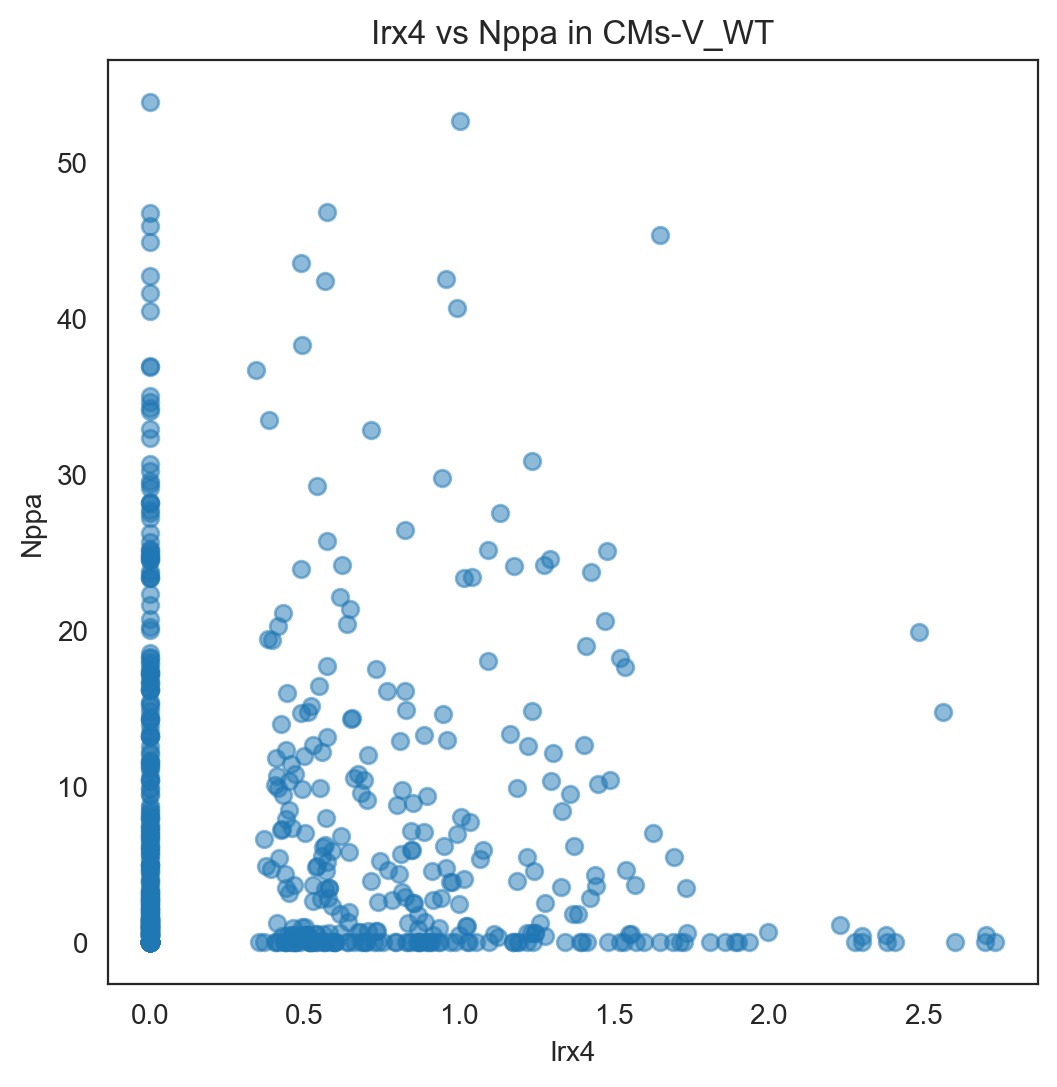

In [71]:
# Define your subset
subset = adata[adata.obs['celltype_x_genotype'] == 'CMs-V_WT']

# Define your genes of interest
gene1 = 'Irx4'  # Replace with your gene name
gene2 = 'Nppa'  # Replace with your gene name

# Extract expression values
x = subset[:, gene1].X.flatten()
y = subset[:, gene2].X.flatten()

# Plot
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel(gene1)
plt.ylabel(gene2)
plt.title(f"{gene1} vs {gene2} in CMs-V_WT")
plt.show()

In [27]:
def return_adata_raw(timepoint):
    adata = sc.read_h5ad(f'data/adata_objects/{timepoint}_subset.h5ad')
    
    if timepoint == 'e85':
        names = ['pSHF_WT','pSHF_KO', 'aSHF_WT', 'aSHF_KO', 'IFT-CMs_WT', 'IFT-CMs_KO', 'V-CMs_WT', 
                 'V-CMs_KO', 'OFT-CMs_WT', 'OFT-CMs_KO', 'PhM_WT', 'PhM_KO', 'LPM_WT', 'LPM_KO', 
                 'PostM_WT', 'PostM_KO', 'MixM_WT', 'MixM_KO', 'C16_WT', 'C16_KO']
    elif timepoint == 'e9':
        names = ['SHF_WT', 'SHF_KO', 'Pe_WT', 'Pe_KO', 'VP_WT', 'VP_KO', 'CMs-A_WT', 'CMs-A_KO', 
                        'CMs-AVC_WT', 'CMs-AVC_KO', 'CMs-V_WT', 'CMs-V_KO', 'CMs-OFT_WT', 'CMs-OFT_KO', 
                        'PhM_WT', 'PhM_KO', 'C11_WT', 'C11_KO']        
    else:
        return
    
    mapping_dict = dict(zip(range(0, len(names)), names))
    adata.obs['celltype_x_genotype'] = adata.obs['cell_type_pool_x_genotype'].map(mapping_dict)    
    
    if timepoint == 'e9':
        adata.obs.loc[adata.obs['celltype_x_genotype'] == 'CMs-AVC_WT', 'celltype_x_genotype'] = 'CMs-A_WT'
    
    
    raw_mtx = mmread(f"./data/adata_objects/{timepoint}_matrix.mtx")
    raw_cells = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_cells.csv", header=None)
    raw_genes = pd.read_csv(f"./data/adata_objects/{timepoint}_raw_genes.csv", header=None)
    x = pd.DataFrame(raw_mtx.toarray()).astype('float64')
    x.index = raw_genes.values.T[0]

    adata.X = x.loc[adata.var_names, :].values.T

    sc.pp.normalize_per_cell(adata)

    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()
    
    return adata

In [61]:
adata = return_adata_raw('e9')

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
oracle = co.Oracle()

5000 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


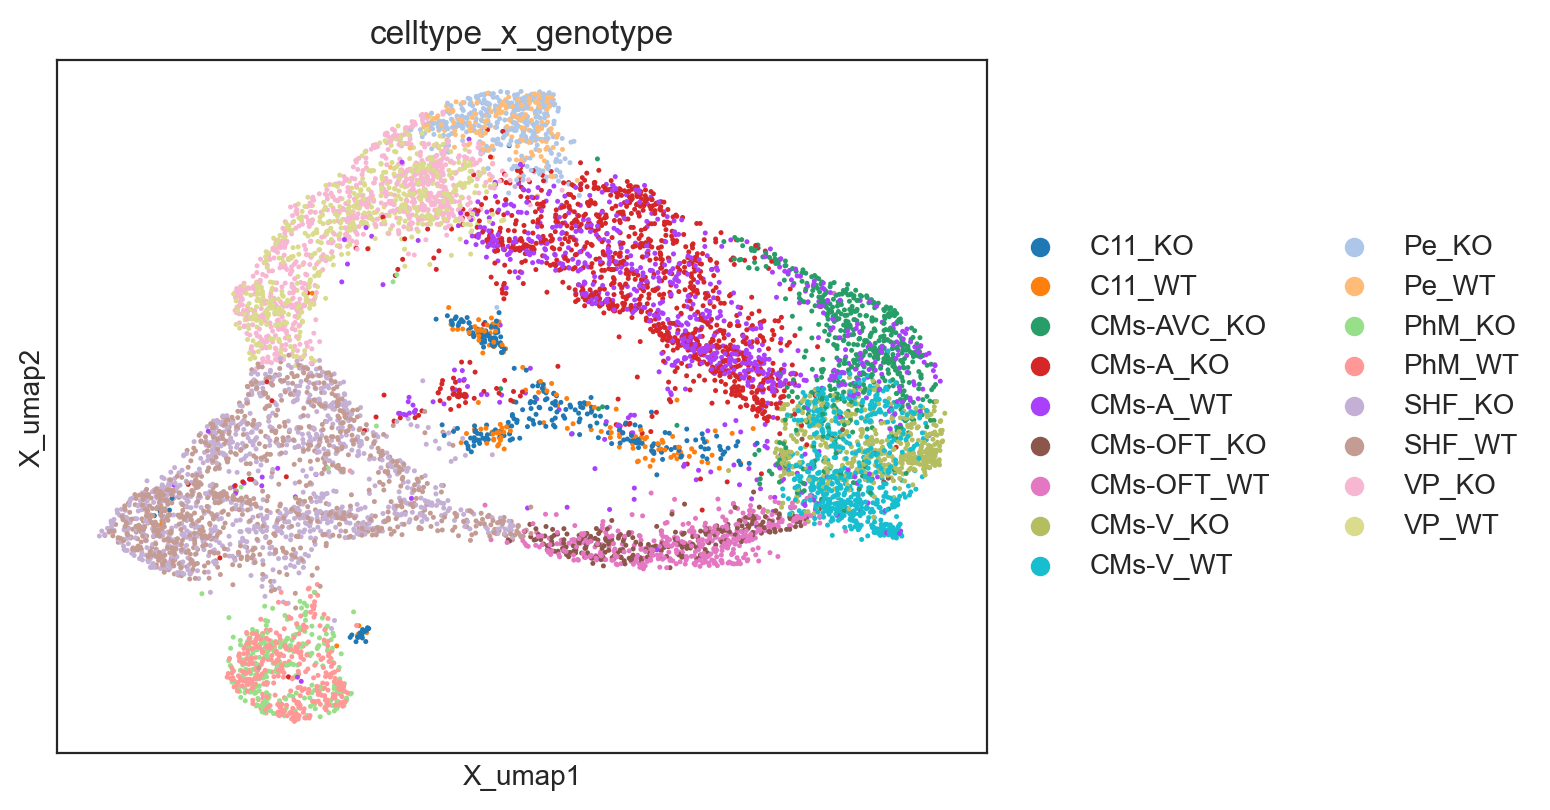

In [63]:
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                               cluster_column_name="celltype_x_genotype",
                               embedding_name="X_umap")
timepoint = '9'
wt_or_ko = 'WT'
base_GRN = pd.read_parquet(f'data/base_grn_outputs/E{timepoint}/base_GRN_dataframe.parquet')
oracle.import_TF_data(TF_info_matrix=base_GRN)
    
# Perform PCA
oracle.perform_PCA()

# Select important PCs
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = min(n_comps, 50)

n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                  b_maxl=k*4, n_jobs=4)

917


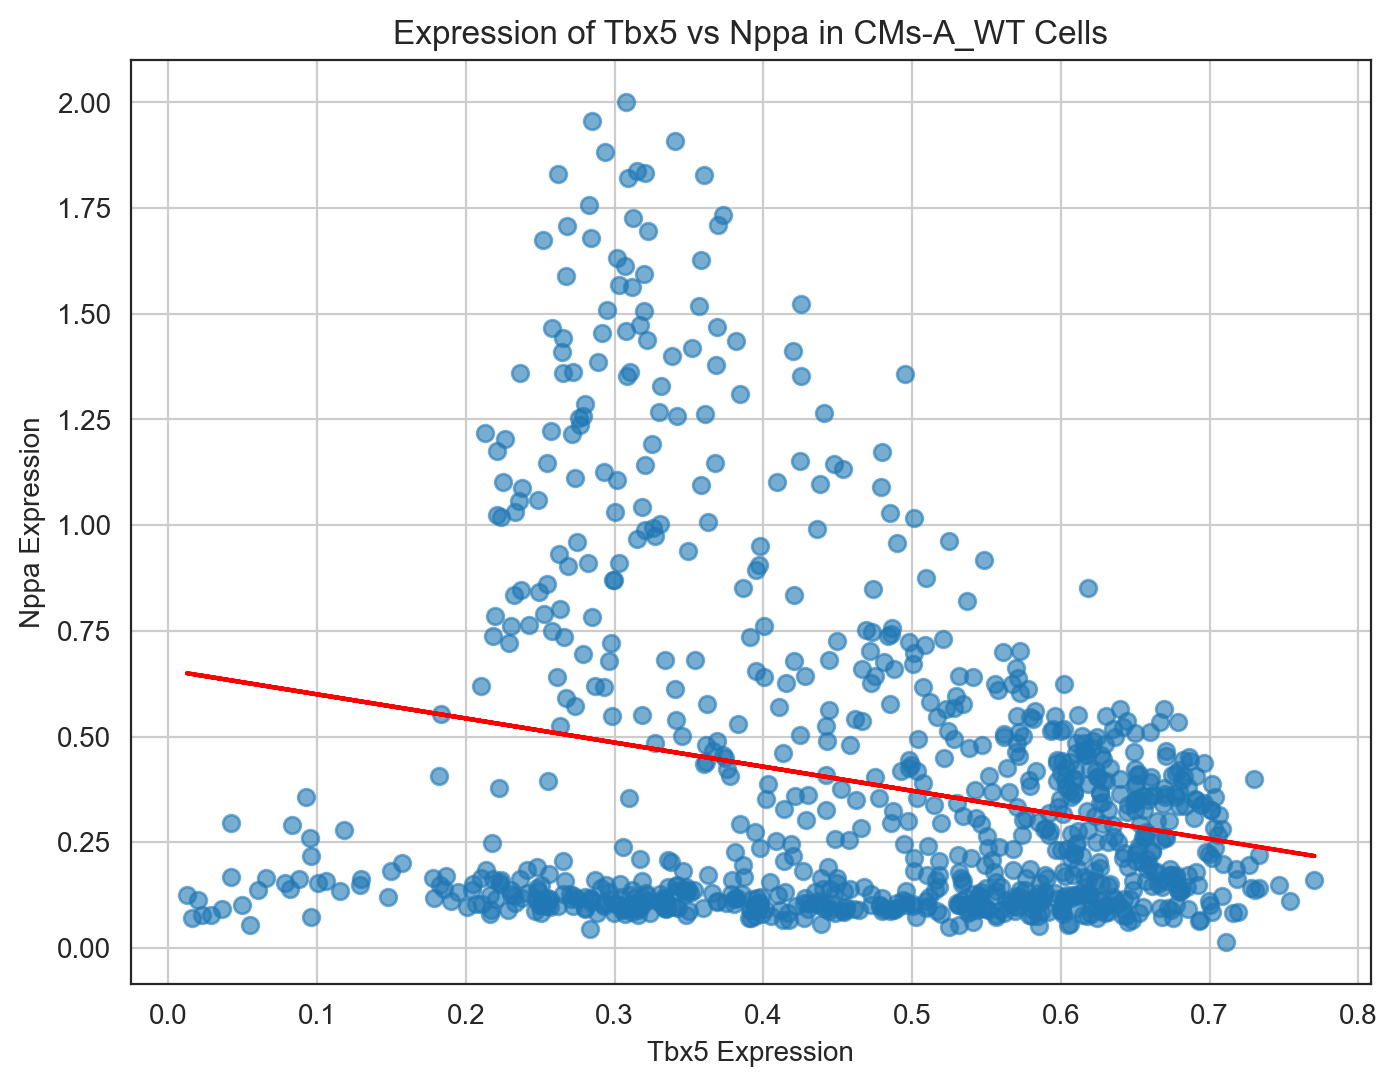

0.05558155441865986


In [73]:
gem_imputed = co.network_analysis.network_construction._adata_to_df(oracle.adata, "imputed_count")

chamber_genotype = 'CMs-A_WT'
# chamber_genotype = 'V-CMs_WT'

imputed_subset = co.network_analysis.network_construction._adata_to_df(oracle.adata[oracle.adata.obs.celltype_x_genotype == chamber_genotype], "imputed_count")

TF = 'Tbx5'
genes_of_interest = ['Nppa']

for x in genes_of_interest:
    # Get the expression values for Mef2c and Myh6
    # mef2c_expr = subset[:, 'Mef2c'].X.flatten()  # Ensure the expression matrix is dense
    # myh6_expr = subset[:, x].X.flatten()
    tf_expr = imputed_subset[TF].values
    print(len(tf_expr))
    gene_expr = imputed_subset[x].values

    model = LinearRegression()
    tf_expr_reshaped = tf_expr.reshape(-1, 1)  # Reshape for sklearn
    model.fit(tf_expr_reshaped, gene_expr)

    # Get predictions and R²
    gene_predicted = model.predict(tf_expr_reshaped)
    r2 = r2_score(gene_expr, gene_predicted)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(tf_expr, gene_expr, alpha=0.6)
    plt.plot(tf_expr, gene_predicted, color='red', label=f'Best Fit (R² = {r2:.2f})')
    plt.title(f"Expression of {TF} vs {x} in {chamber_genotype} Cells")
    plt.xlabel(f"{TF} Expression")
    plt.ylabel(f"{x} Expression")
    plt.grid(True)
    plt.show()
    print(r2)